In [1]:
#!pip install pytorch-ignite
#!pip install torchnet

In [2]:
import sys
import os
import scipy.ndimage as nd
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure as sk
from utils import utils
plt.style.use('ggplot')

In [3]:
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils import data

import torch
import PIL.ImageOps

In [4]:
available_device = "cuda" if torch.cuda.is_available() else "cpu"

#### Load dataset

In [5]:
transformations = [tfs.RandomAffine(0., scale=(0.5, 1.), fillcolor=0),
                   tfs.Resize((64, 64)),
                   tfs.Grayscale(1),
                   tfs.Lambda(lambda x: PIL.ImageOps.invert(x))]

imagenet_data = datasets.ImageFolder('data/png_clasificados/',
                                     transform=tfs.Compose(transformations))

data_loader = data.DataLoader(imagenet_data, batch_size=4, shuffle=True)

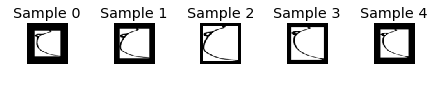

In [6]:
fig = plt.figure()

for i in range(len(imagenet_data)):
    sample = imagenet_data[i + 10]
    #print(sample)
    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    plt.imshow(np.asarray(sample[0]), cmap=plt.cm.gray_r)
    ax.set_title('Sample {}'.format(i))
    ax.axis('off')

    if i == 4:
        plt.show()
        break

#### Process type of vessels for classification

In [7]:
df = utils.create_df_from_files(path='data/clases/')
# destination = "data/perfiles_CATA/png_clasificados/"
# path = "data/perfiles_CATA/png"
# utils.create_folder_pytorch_format(df, destination, path)

1
2
3
4
5
6
7
8
9
10
11


#### Build and train classifier

In [8]:
imagenet_data = datasets.ImageFolder('data/png_clasificados/',
                                     transform=tfs.Compose([tfs.RandomHorizontalFlip(p=0.7),
                                                           tfs.RandomAffine(0, scale=(0.7, 1.), fillcolor=0),
                                                           tfs.Resize((64, 64)),
                                                           tfs.Grayscale(1),
                                                           tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
                                                           tfs.ToTensor(),
                                                           tfs.Normalize((0.5,), (0.5,))]))

#data_loader = data.DataLoader(imagenet_data, batch_size=64, shuffle=True)

In [9]:
splits_len = round(len(imagenet_data.samples)*0.2), round(len(imagenet_data.samples)*0.1), round(len(imagenet_data.samples)*0.7)

In [10]:
splits_len = splits_len if np.sum(splits_len) == len(imagenet_data.samples) else splits_len[0], splits_len[1], splits_len[2]+1

#### Random split

In [11]:
splits = utils.random_split(imagenet_data, splits_len)

train_loader = data.DataLoader(splits[2], batch_size=32, shuffle=True)
val_loader = data.DataLoader(splits[1], batch_size=32, shuffle=True)
test_loader = data.DataLoader(splits[0], batch_size=32, shuffle=True)


In [12]:
import torch.optim as optim
from torch import nn
from models.classifier import _C
import visdom
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import TopKCategoricalAccuracy, Loss
from ignite.handlers import ModelCheckpoint
import torch.nn.functional as F

In [13]:
pwd

'/home/pablo/Codigo/vasijas'

In [15]:
C =_C(input_h_w=64)
C = C.to(available_device)
criterion = nn.CrossEntropyLoss().to(available_device)
C_optimizer = optim.Adam(C.parameters(), lr=0.0002, betas=(0.5, 0.999))

#vis = visdom.Visdom()
log_interval = 10
trainer = create_supervised_trainer(C, C_optimizer, F.cross_entropy, device=available_device)

handler_checkpoint = ModelCheckpoint('models/checkpoint_data', 'cnn_vessels', save_interval=2, n_saved=2, create_dir=True, require_empty=False, save_as_state_dict=True)
trainer.add_event_handler(Events.EPOCH_COMPLETED, handler_checkpoint, {'model': C, 'optimizer': C_optimizer})


evaluator = create_supervised_evaluator(C, metrics={'accuracy': TopKCategoricalAccuracy(),
                                                     'ce_ll': Loss(F.cross_entropy)},
                                           device=available_device)

"""
train_avg_loss_window = utils.create_plot_window(vis, '#Iterations', 'Loss', 
                                                 'Training Average Loss')
train_avg_accuracy_window = utils.create_plot_window(vis, '#Iterations', 'Accuracy',
                                                     'Training Average Accuracy')
val_avg_loss_window = utils.create_plot_window(vis, '#Epochs', 'Loss',
                                               'Validation Average Loss')
val_avg_accuracy_window = utils.create_plot_window(vis, '#Epochs', 'Accuracy',
                                                   'Validation Average Accuracy')
"""


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_nll = metrics['ce_ll']
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(engine.state.epoch, avg_accuracy, avg_nll))
    #vis.line(X=np.array([engine.state.epoch]), Y=np.array([avg_accuracy]),
    #         win=train_avg_accuracy_window, update='append')
    #vis.line(X=np.array([engine.state.epoch]), Y=np.array([avg_nll]),
    #         win=train_avg_loss_window, update='append')

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_nll = metrics['ce_ll']
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(engine.state.epoch, avg_accuracy, avg_nll))
    #vis.line(X=np.array([engine.state.epoch]), Y=np.array([avg_accuracy]),
    #         win=val_avg_accuracy_window, update='append')
    #vis.line(X=np.array([engine.state.epoch]), Y=np.array([avg_nll]),
    #         win=val_avg_loss_window, update='append')

trainer.run(train_loader, max_epochs=500)

Training Results - Epoch: 1  Avg accuracy: 0.74 Avg loss: 2.33
Validation Results - Epoch: 1  Avg accuracy: 0.73 Avg loss: 2.33
Training Results - Epoch: 2  Avg accuracy: 0.90 Avg loss: 1.99
Validation Results - Epoch: 2  Avg accuracy: 0.91 Avg loss: 1.93
Training Results - Epoch: 3  Avg accuracy: 0.92 Avg loss: 1.88
Validation Results - Epoch: 3  Avg accuracy: 0.94 Avg loss: 1.82
Training Results - Epoch: 4  Avg accuracy: 0.91 Avg loss: 1.83
Validation Results - Epoch: 4  Avg accuracy: 0.91 Avg loss: 1.76
Training Results - Epoch: 5  Avg accuracy: 0.91 Avg loss: 1.82
Validation Results - Epoch: 5  Avg accuracy: 0.89 Avg loss: 1.75
Training Results - Epoch: 6  Avg accuracy: 0.89 Avg loss: 1.83
Validation Results - Epoch: 6  Avg accuracy: 0.89 Avg loss: 1.77
Training Results - Epoch: 7  Avg accuracy: 0.91 Avg loss: 1.80
Validation Results - Epoch: 7  Avg accuracy: 0.91 Avg loss: 1.75
Training Results - Epoch: 8  Avg accuracy: 0.89 Avg loss: 1.81
Validation Results - Epoch: 8  Avg accura

In [ ]:
val_loader.dataset, train_loader.dataset, test_loader.dataset

In [ ]:
from torchsummary import summary
if available_device == "cuda":
    summary(C, (1, 64, 64))

### Confusion matrix and classification report

In [ ]:
import torchnet

confusion_window = utils.create_plot_window(vis, 'True Labels', 'Predicted', 'Confusion Matrix')

confusion_matrix = torchnet.meter.ConfusionMeter(11, normalized=True)
for ii, data_ in enumerate(test_loader):
    input_, label = data_
    val_input = Variable(input_).to(available_device)
    val_label = Variable(label.type(torch.LongTensor)).to(available_device)
    score = C(val_input)
    confusion_matrix.add(score.data.squeeze(), label.type(torch.LongTensor))
    
np.set_printoptions(precision=3)
print(confusion_matrix.value())
print(confusion_matrix.conf)
vis.heatmap(confusion_matrix.value(), win=confusion_window)

In [ ]:
from sklearn import metrics

def iterations_test(C, test_loader):
    y_real = list()
    y_pred = list()

    for ii, data_ in enumerate(test_loader):
        input_, label = data_
        val_input = Variable(input_).to(available_device)
        val_label = Variable(label.type(torch.LongTensor)).to(available_device)
        score = C(val_input)
        _, y_pred_batch = torch.max(score, 1)
        y_pred_batch = y_pred_batch.cpu().squeeze().numpy()
        y_real_batch = val_label.cpu().data.squeeze().numpy()
        y_real.append(y_real_batch.tolist())
        y_pred.append(y_pred_batch.tolist())

    y_real = [item for batch in y_real for item in batch]
    y_pred = [item for batch in y_pred for item in batch]
    
    return y_real, y_pred

In [ ]:
y_real, y_pred = iterations_test(C, test_loader)
print(metrics.classification_report(np.array(y_pred), np.array(y_real)))

In [ ]:
avg_acc = list()
for i in range(5):
    y_real, y_pred = iterations_test(C, test_loader)
    avg_acc.append(metrics.accuracy_score(np.array(y_pred), np.array(y_real)))
print(np.mean(avg_acc), avg_acc)